In [13]:
import torch
import numpy as np
from ufno import *
from lploss import *
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'your/data/path'

test_a = torch.load(f'{DATA_DIR}/dP_test_a.pt')
test_u = torch.load(f'{DATA_DIR}/dP_test_u.pt')

print(test_a.shape)
print(test_u.shape)

torch.Size([500, 96, 200, 24, 12])
torch.Size([500, 96, 200, 24])


# load pre-trained

In [7]:
device = torch.device('cuda:0')
model = torch.load('trained_model/dP_UFNO_4500_trained')
model.to(device)

Net3d(
  (conv1): SimpleBlock3d(
    (fc0): Linear(in_features=12, out_features=36, bias=True)
    (conv0): SpectralConv3d()
    (conv1): SpectralConv3d()
    (conv2): SpectralConv3d()
    (conv3): SpectralConv3d()
    (conv4): SpectralConv3d()
    (conv5): SpectralConv3d()
    (w0): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w4): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w5): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (unet3): U_net(
      (conv1): Sequential(
        (0): Conv3d(36, 36, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0, inplace=False)
      )
      (conv2): Sequential(
        (0): Con

In [8]:
# Prepare for plotting
dx = np.cumsum(3.5938*np.power(1.035012, range(200))) + 0.1
X, Y = np.meshgrid(dx, np.linspace(0,200,num = 96))

def pcolor(x):
    plt.jet()
    return plt.pcolor(X[:thickness, :], Y[:thickness, :], np.flipud(x), shading='auto')

def dnorm_dP(dP):
    dP = dP * 18.772821433027488
    dP = dP + 4.172939172019009 
    return dP

times = np.cumsum(np.power(1.421245, range(24)))
time_print = []
for t in range(times.shape[0]):
    if times[t]<365:
        title = str(int(times[t]))+' d'
        time_print = np.append(time_print,title)
    else:
        title = f'{round(int(times[t])/365, 1)} y' 
        time_print = np.append(time_print,title)

dnorm_inj = lambda a : (a * (3e6 - 3e5) + 3e5) / (1e6 /365*1000/1.862)
dnorm_temp = lambda a : a * (180 - 30) + 30
dnorm_P = lambda a : a * (300 - 100) + 100
dnorm_lam = lambda a : a * 0.4 + 0.3
dnorm_Swi = lambda a : a * 0.2 + 0.1

In [9]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a[:1,...], 
                                                                         test_u[:1,...]), 
                                          batch_size=1, 
                                          shuffle=False)

# Visualize predictions

Params: injection rate: 1.92 MT/yr, temperature: 121.2 C, initial pressure: 258.3 bar, Swi: 0.28, lan: 0.45


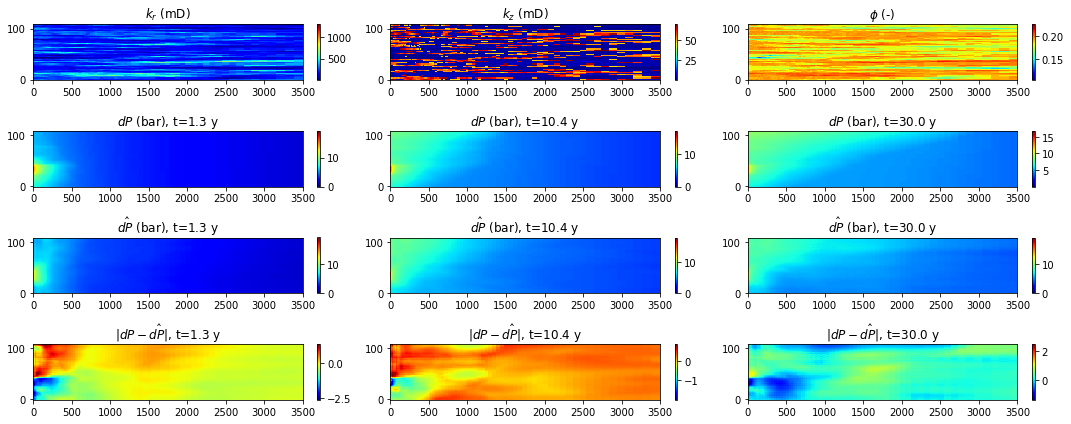

In [16]:
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
pred = model(x).view(-1,96,200,24)

y_plot = y.cpu().detach().numpy()
x_plot = x.cpu().detach().numpy()
pred_plot = dnorm_dP(pred.cpu().detach().numpy())

# reservior have different thickness as marked in the permeability map
mask = x_plot[0,:,:,0,0] != 0 
thickness = sum(mask[:,0])

# extract input parameters
poro_map = x_plot[0,:,:,0,2][mask].reshape((thickness, -1))
kr_map = np.exp(x_plot[0,:,:,0,0][mask].reshape((thickness, -1))*15)
kz_map = np.exp(x_plot[0,:,:,0,1][mask].reshape((thickness, -1))*15)

inj_rate = dnorm_inj(x_plot[0,0,0,0,4])
temperature = dnorm_temp(x_plot[0,0,0,0,5])
pressure = dnorm_P(x_plot[0,0,0,0,6])
Swi = dnorm_Swi(x_plot[0,0,0,0,7])
lam = dnorm_lam(x_plot[0,0,0,0,8])

print(f'Params: injection rate: {inj_rate:.2f} MT/yr, temperature: {temperature:.1f} C, initial pressure: {pressure:.1f} bar, Swi: {Swi:.2f}, lan: {lam:.2f}')

t_lst = [14,20,23]
plt.figure(figsize=(15,6))    
for j, t in enumerate(t_lst):   
    plt.subplot(4,3,j+1)
    if j == 2:
        pcolor(poro_map)
        plt.title('$\phi$ (-)')
    elif j == 1:
        pcolor(kz_map)
        plt.title('$k_z$ (mD)')
    else:
        pcolor(kr_map)
        plt.title('$k_r$ (mD)')
    plt.colorbar(fraction=0.02)
    plt.xlim([0,3500])        

    plt.subplot(4,3,j+4)
    pcolor(y_plot[0,:,:,t][mask].reshape((thickness, -1)))
    plt.title('$dP$ (bar), '+f't={time_print[t]}')
    plt.colorbar(fraction=0.02)
    plt.xlim([0,3500])

    plt.subplot(4,3,j+7)
    pcolor(pred_plot[0,:,:,t][mask].reshape((thickness, -1)))
    plt.title('$\hat{dP}$ (bar), '+f't={time_print[t]}')
    plt.colorbar(fraction=0.02)
    plt.xlim([0,3500])

    plt.subplot(4,3,j+10)
    pcolor((pred_plot[0,:,:,t][mask].reshape((thickness, -1))-y_plot[0,:,:,t][mask].reshape((thickness, -1))))
    plt.colorbar(fraction=0.02)
    plt.title('|$dP-\hat{dP}$|, '+f't={time_print[t]}')
    plt.xlim([0,3500])
plt.tight_layout()
plt.show()